In [1]:
from sklearn.preprocessing import LabelEncoder
import config
from keras.preprocessing.sequence import pad_sequences
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import boto3
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
import sys
from tensorflow import keras

In [2]:
from keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
def trainTestSplit(df,n):
    random.seed(123)
    df1 = df['ASSET_CLASS'].value_counts().rename_axis('Assets').reset_index(name = 'counts')
    df_new = df1[df1['counts']>=n] # Train Test split 75% - train
    assets = list(df_new['Assets'])
    dffiltered = df[df['ASSET_CLASS'].isin(assets)]
    dffiltered['ASSET_CLASS_CODES'] = pd.Categorical(dffiltered['ASSET_CLASS'])
    dffiltered['ASSET_CLASS_CODES'] = dffiltered['ASSET_CLASS_CODES'].cat.codes
    #x = dffiltered.drop(columns = ['ASSET_CLASS','ASSET_CLASS_CODES','BUSINESS_UNIT','PSC_CODE','FUND_SUBOBJCLASS','ORDER_DATE','ORDER_TITLE',                                                                                                                                                      
     #       'LINE_DESCRIPTION', 'VENDOR_NAME', 'VENDOR_COUNTRY', 'ASSET_CLASS_DESCRIPTION','text_fields','SUB_OBJ_DESCR','OBJ_CODE'])
    #x = dffiltered[['text_fields', 'ASSET_CLASS_CODES']]
    
    x = dffiltered['text_fields']
    #xcols = list(x.columns)
    y = pd.get_dummies(dffiltered['ASSET_CLASS_CODES'])
    # creating instance of labelencoder    
    X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = 0.20, stratify = y)
    print(' Number of Assets ' + str(len(set(list(dffiltered['ASSET_CLASS'])))))
    #dict_codes = pd.Series(df.ASSET_CLASS.values, index = df.ASSET_CLASS_CODES).to_dict()
    return X_train, X_test,  Y_train, Y_test

In [4]:
def scores(y_pred, Y_test):
    print('Accuracy:   '+str(accuracy_score(y_pred, Y_test)))
    print('Precision Macro:   '+ str(precision_score(y_pred, Y_test,average = 'macro')))
    print('Recall Macro:     '+str(recall_score(y_pred, Y_test, average = 'macro')))
    print('F1 Score Macro:     '+str(f1_score(y_pred, Y_test, average = 'macro')))
    print('\n')

In [5]:
def generateEmbeddingIndex():
    print('Indexing word vectors.')
    embeddings_index = {}
    with open((config.utils_dir+config.glove_txt_300d)) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [6]:
def scores(y_pred, Y_test):
    print('Accuracy:   '+str(accuracy_score(y_pred, Y_test)))
    print('Precision Macro:   '+ str(precision_score(y_pred, Y_test,average = 'macro')))
    print('Recall Macro:     '+str(recall_score(y_pred, Y_test, average = 'macro')))
    print('F1 Score Macro:     '+str(f1_score(y_pred, Y_test, average = 'macro')))
    print('\n')

In [7]:
#Tokenize text of the training data with keras text preprocessing functions
def cnn(X_train, X_test, Y_train, Y_test, wordembeddings, vocab_size):
    
    #NUM_WORDS = vocab_size
    EMBEDDING_DIM=300
    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    sequences_train = tokenizer.texts_to_sequences(X_train)
    sequences_valid=tokenizer.texts_to_sequences(X_test)
    
    max_length_sentence = X_train.str.split().str.len().max()
    print("The number of words in the longest sentence", max_length_sentence)
    
    X_train = pad_sequences(sequences_train,maxlen=max_length_sentence)
    X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1])
    
    y_train = np.asarray(Y_train)
    y_val = np.asarray(Y_test)
    
    print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
    print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)
    
    
    EMBEDDING_DIM=300
    vocabulary_size=len(word_index)+1
    embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
    
    for word, i in word_index.items():
        try:
            embedding_vector = model[word]
        except:
            try:
                embedding_vector = model[word.title()]
            except:
                try:
                    embedding_vector = model[word.upper()]
                except:
                     embedding_vector = np.array([round(np.random.rand(),8) for i in range(0,300)])

        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False) #Try with True
    
    
    
    sequence_length = X_train.shape[1]
    filter_sizes = [5,6]
    num_filters = 100
    drop = 0.1

    inputs = Input(shape=(sequence_length,))
    embedding = embedding_layer(inputs)
    reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)
    
    conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu')(reshape)
    conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu')(reshape)
    

    maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
    maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

    merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
    flatten = Flatten()(merged_tensor)
    reshape = Reshape((2*num_filters,))(flatten)
    #dropout = Dropout(drop)(flatten)
    conc = Dense(40)(flatten)
    output = Dense(units=Y_train.shape[1], activation='softmax')(conc)

    # this creates a model that includes
    model = Model(inputs, output)
    
    # Compiling Model using optimizer
    opt = Adam(lr=1e-3)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
    model.summary()
    
    
    # Fitting Model to the data
    callbacks = [EarlyStopping(monitor='val_loss')]
    hist_adam = model.fit(X_train, y_train, batch_size=1000, epochs=200, verbose=1, validation_data=(X_val, y_val),
             callbacks=callbacks)
    
    
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.plot(hist_adam.history['loss'], color='b', label='Training Loss')
    plt.plot(hist_adam.history['val_loss'], color='r', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.savefig('/home/ubuntu/asset_classification/results/cnn_model_plot_dataset2.png')
    #y_pred = model.predict(X_test)
    #scores(y_pred, Y_test)
    model.save(config.cnn_dataset2)
    return model,hist_adam


In [8]:
def main():
    #data_location = connect()
    df = read_files()
    df = df.replace(np.nan, '', regex = True)

    X_train, X_test, Y_train, Y_test = trainTestSplit(df,100)

    # wordembeddings
    wordembeddings = generateEmbeddingIndex()
    print(wordembeddings)
    
    #cnn(X_train, X_test, Y_train, Y_test, wordembeddings)
    print(len(wordembeddings))

In [9]:
df = pd.read_csv(config.datasets_dir + config.preprocessed_filename_deep_learning)
#df_optimized = pd.read_csv(config.datasets_dir + config.optimized_dataset)
#df['ASSET_CLASS'] = df_optimized['ASSET_CLASS']

In [10]:
X_train, X_test, Y_train, Y_test = trainTestSplit(df,2)

<ipython-input-3-fde83473a08c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffiltered['ASSET_CLASS_CODES'] = pd.Categorical(dffiltered['ASSET_CLASS'])
<ipython-input-3-fde83473a08c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffiltered['ASSET_CLASS_CODES'] = dffiltered['ASSET_CLASS_CODES'].cat.codes


 Number of Assets 909


In [11]:
wordembeddings = generateEmbeddingIndex()

Indexing word vectors.
Found 2195885 word vectors.


In [12]:
vocabulary = df["text_fields"].str.lower().str.split(" ").apply(pd.Series).stack().unique()
#cnn(X_train, X_test, Y_train, Y_test, wordembeddings)
print(vocabulary)

['transformers' 'warehouse' 'location' ... 'subscr' 'medialess' 'pry']


In [13]:
vocab_size = len(vocabulary)
print("Length of vocabulary", len(vocabulary))

Length of vocabulary 46467


Found 43918 unique tokens.
The number of words in the longest sentence 231
Shape of X train and X validation tensor: (85536, 231) (21385, 231)
Shape of label train and validation tensor: (85536, 909) (21385, 909)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 231)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 231, 300)     13175700    input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 231, 300, 1)  0           embedding[0][0]                  
_______________________________________________________________________________

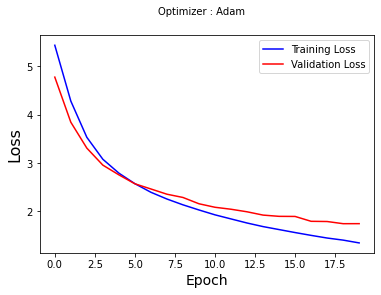

In [14]:
model, history = cnn(X_train, X_test, Y_train, Y_test, wordembeddings, vocab_size)